In [1]:
cd ..

/home/scott/Documents/git/bite-me


In [2]:
import pandas as pd
import numpy as np
import datetime
import itertools
import copy
import pickle
import sklearn
import sklearn.svm
import sklearn.linear_model
import sklearn.cross_validation
import sklearn.decomposition
import sklearn.manifold
import sklearn.metrics
from eat_it import StratifiedPercentileKFold
from eat_it import scalers
from eat_it import params

    
train = pd.read_csv('data/train.csv', encoding="utf-8")
# Add age in days
end_dt = datetime.datetime.strptime('2015-1-1', "%Y-%m-%d")
train['Age'] = [(end_dt - datetime.datetime.strptime(open_dt, "%m/%d/%Y")).days for open_dt in train['Open Date']]
# add size as boolean field
train['isBig'] = train['City Group']=='Big Cities'
# add each of the big cities as boolean field
#train['isIstanbul'] = train['City']=='İstanbul'
#train['isAnkara'] = train['City']=='Ankara'
#train['isIzmir'] = train['City']=='İzmir'
# add boolean field for type
train['isFC'] = train['Type']=='FC'
train['isDT'] = train['Type']=='DT'
train['isMB'] = train['Type']=='MB'
# Note when there is the missing 17 fields
train['missingSource'] = train[params.xor_cols].apply(lambda x: np.all(x==0), axis=1)


with open('data/genuinetestmap.pkl', 'rb') as hf:
    gtm = pickle.load(hf)


gtest = pd.read_csv('data/genuinetest.csv', encoding="utf-8")
# Add age in days
end_dt = datetime.datetime.strptime('2015-1-1', "%Y-%m-%d")
gtest['Age'] = [(end_dt - datetime.datetime.strptime(open_dt, "%m/%d/%Y")).days for open_dt in gtest['Open Date']]
# add size as boolean field
gtest['isBig'] = gtest['City Group']=='Big Cities'
# add each of the big cities as boolean field
#gtest['isIstanbul'] = gtest['City']=='İstanbul'
#gtest['isAnkara'] = gtest['City']=='Ankara'
#gtest['isIzmir'] = gtest['City']=='İzmir'
# add boolean field for type
gtest['isFC'] = gtest['Type']=='FC'
gtest['isDT'] = gtest['Type']=='DT'
gtest['isMB'] = gtest['Type']=='MB'
# Note when there is the missing 17 fields
gtest['missingSource'] = gtest[params.xor_cols].apply(lambda x: np.all(x==0), axis=1)


test = pd.read_csv('data/test.csv', encoding="utf-8")
# Add age in days
end_dt = datetime.datetime.strptime('2015-1-1', "%Y-%m-%d")
test['Age'] = [(end_dt - datetime.datetime.strptime(open_dt, "%m/%d/%Y")).days for open_dt in test['Open Date']]
# add size as boolean field
test['isBig'] = test['City Group']=='Big Cities'
# add each of the big cities as boolean field
#test['isIstanbul'] = test['City']=='İstanbul'
#test['isAnkara'] = test['City']=='Ankara'
#test['isIzmir'] = test['City']=='İzmir'
# add boolean field for type
test['isFC'] = test['Type']=='FC'
test['isDT'] = test['Type']=='DT'
test['isMB'] = test['Type']=='MB'
# Note when there is the missing 17 fields
test['missingSource'] = test[params.xor_cols].apply(lambda x: np.all(x==0), axis=1)


# Merge Test and Train together, without having revenue for all entries
unlabelled_data = pd.concat((train, gtest), ignore_index=True)


#####################################
# Don't use public test revenues
#data = train

# Add known revenues from public test data
gtestrevenue = pd.read_csv('data/genuinetestrevenue.csv', encoding="utf-8")
labelled_test = pd.merge(gtest, gtestrevenue, on='Id')
# Merge all available training data together
data = pd.concat((train, labelled_test), ignore_index=True)
#####################################


# Assemble list of columns
Pcols = ['P'+str(i) for i in range(1,38)]
PMcols = params.xor_cols
PVcols = [i for i in Pcols if i not in params.xor_cols]
Gcols = ['Age']
Ocols = ['isBig','isFC','isDT','isMB']
cols = Pcols + Gcols + Ocols

# Targets
y = data['revenue'].values

X_indices = data['Id'].values
uX_indices = unlabelled_data['Id'].values

index_is_labelled = [i in X_indices for i in uX_indices]
index_is_labelled = np.asarray(index_is_labelled)

unlabelled_data_nomissing = np.logical_not(unlabelled_data['missingSource'].values)
data_nomissing = np.logical_not(data['missingSource'].values)
test_nomissing = np.logical_not(test['missingSource'].values)

# Other (already one-hot columns) can stay as they are
XO = data.as_matrix(Ocols).astype(np.float)
tXO = test.as_matrix(Ocols).astype(np.float)

# Need to take logs because sometimes Age can't be mapped correctly by BoxCox
u = np.log(unlabelled_data.as_matrix(Gcols).astype(np.float))
d = np.log(data.as_matrix(Gcols).astype(np.float))
t = np.log(test.as_matrix(Gcols).astype(np.float))
s = scalers.BoxCoxScaler().fit(u)
XG = s.transform(d)
tXG = s.transform(t)

# Valid-always columns
u = unlabelled_data.as_matrix(PVcols).astype(np.float)
d = data.as_matrix(PVcols).astype(np.float)
t = test.as_matrix(PVcols).astype(np.float)
s = scalers.BoxCoxScaler().fit(u)
XPV = s.transform(d)
uXPV = s.transform(u)
tXPV = s.transform(t)

# Missing-sometimes columns
u = unlabelled_data.as_matrix(PMcols).astype(np.float)[unlabelled_data_nomissing]
d = data.as_matrix(PMcols).astype(np.float)
t = test.as_matrix(PMcols).astype(np.float)
s = scalers.BoxCoxScaler(known_min=0).fit(u)
XPM = s.transform(d)
uXPM = s.transform(u)
tXPM = s.transform(t)

In [3]:
import pymc as pm

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


In [9]:
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

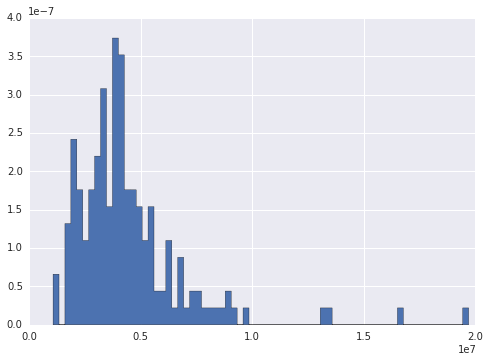

In [10]:
_ = plt.hist(y, bins=70, normed=True, histtype="stepfilled")

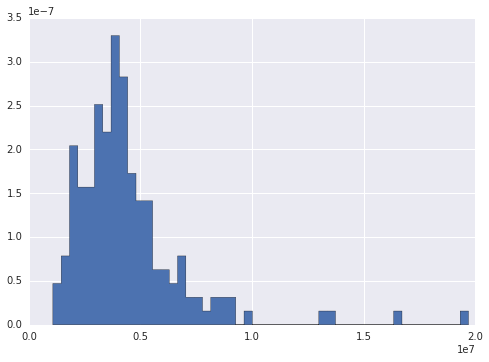

In [12]:
_ = plt.hist(y, bins=50, normed=True, histtype="stepfilled")

In [34]:
mu_init = np.log(np.median(y))
sigma_init = np.sqrt((np.log(np.mean(y))-mu_init)*2)
tau_init = 0.5/(np.log(np.mean(y))-mu_init)

rev = pm.Lognormal('rev', mu=mu_init, tau=tau_init)

In [35]:
# generate some observations
observations_A = pm.rlognormal(mu_init, tau_init, 10000)

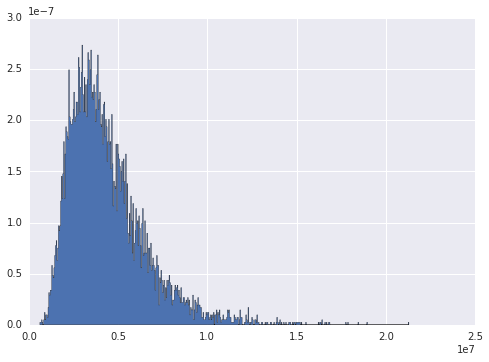

In [36]:
_ = plt.hist(observations_A, bins=500, normed=True, histtype="stepfilled")

In [37]:
obs_y = pm.Lognormal("obs_y", rev, value=y, observed=True)

In [38]:
mcmc = pm.MCMC([rev, obs_y])
mcmc.sample(50000, 10000)

 [-----------------100%-----------------] 50000 of 50000 complete in 2.6 sec

In [39]:
rev_samples = mcmc.trace('rev')[:]

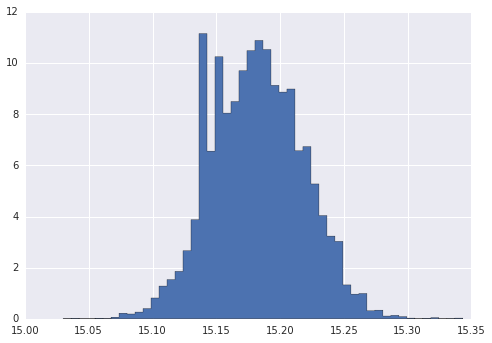

In [40]:
_ = plt.hist(rev_samples, bins=50, normed=True, histtype="stepfilled")

In [42]:
mu_init = np.log(np.median(y))
sigma_init = np.sqrt((np.log(np.mean(y))-mu_init)*2)
tau_init = 0.5/(np.log(np.mean(y))-mu_init)

rev_mu = pm.Normal('rev_mu', mu=mu_init, tau=0.5/mu_init)
rev_tau = pm.Normal('rev_tau', mu=tau_init, tau=0.5/tau_init)

rev = pm.Lognormal('rev', mu=rev_mu, tau=rev_tau)

In [44]:
mcmc = pm.MCMC([obs_y, rev, rev_mu, rev_tau])
mcmc.sample(50000, 10000)

 [-----------------100%-----------------] 50000 of 50000 complete in 4.0 sec

/usr/local/lib/python3.4/dist-packages/pymc/StepMethods.py:779: UserWarning: DrawFromPrior jumped to forbidden value
  warnings.warn('DrawFromPrior jumped to forbidden value')


In [54]:
mcmc = pm.MCMC([obs_y, rev, rev_mu, rev_tau])
mcmc.sample(100000, 60000)

 [-----------------100%-----------------] 100000 of 100000 complete in 8.0 sec

/usr/local/lib/python3.4/dist-packages/pymc/StepMethods.py:779: UserWarning: DrawFromPrior jumped to forbidden value
  warnings.warn('DrawFromPrior jumped to forbidden value')


In [55]:
mu_samples = mcmc.trace("rev_mu")[:]
tau_samples = mcmc.trace("rev_tau")[:]
rev_samples = mcmc.trace("rev")[:]

(array([  1.46546270e-08,   9.58532126e-10,   5.21951541e-10,
          3.59854789e-10,   2.69080608e-10,   2.19911260e-10,
          1.81008040e-10,   1.45887077e-10,   1.36161272e-10,
          1.11306436e-10,   9.34757935e-11,   8.26693434e-11,
          6.97016033e-11,   6.91612808e-11,   6.64596682e-11,
          6.15967657e-11,   5.78145081e-11,   5.45725731e-11,
          4.70080580e-11,   3.89032204e-11,   4.10645105e-11,
          3.45806404e-11,   3.62016079e-11,   3.40403179e-11,
          3.51209629e-11,   3.51209629e-11,   3.13387053e-11,
          2.91774153e-11,   3.07983828e-11,   2.75564478e-11,
          3.34999954e-11,   2.91774153e-11,   2.43145128e-11,
          1.67499977e-11,   2.64758028e-11,   2.48548353e-11,
          2.21532227e-11,   2.26935453e-11,   2.21532227e-11,
          2.32338678e-11,   1.72903202e-11,   1.29677401e-11,
          1.72903202e-11,   2.21532227e-11,   2.05322552e-11,
          1.99919327e-11,   1.83709652e-11,   1.78306427e-11,
        

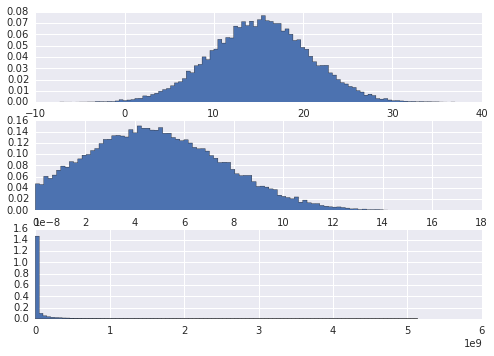

In [56]:
ax = plt.subplot(311)
plt.hist(mu_samples, histtype='stepfilled', bins=100, normed=True, label='mu')

ax = plt.subplot(312)
plt.hist(tau_samples, histtype='stepfilled', bins=100, normed=True, label='tau')

ax = plt.subplot(313)
plt.hist(rev_samples[rev_samples<np.percentile(rev_samples,90)], histtype='stepfilled', bins=100, normed=True, label='rev')

In [62]:
print(y.mean(), rev_samples[rev_samples<np.percentile(rev_samples,90)].mean())

4400466.17538 215614574.156


In [58]:
mcmc = pm.MCMC([obs_y, rev, rev_mu, rev_tau])
mcmc.sample(100000)

 [-----------------100%-----------------] 100000 of 100000 complete in 8.5 sec

/usr/local/lib/python3.4/dist-packages/pymc/StepMethods.py:779: UserWarning: DrawFromPrior jumped to forbidden value
  warnings.warn('DrawFromPrior jumped to forbidden value')


In [55]:
mu_samples = mcmc.trace("rev_mu")[:]
tau_samples = mcmc.trace("rev_tau")[:]
rev_samples = mcmc.trace("rev")[:]

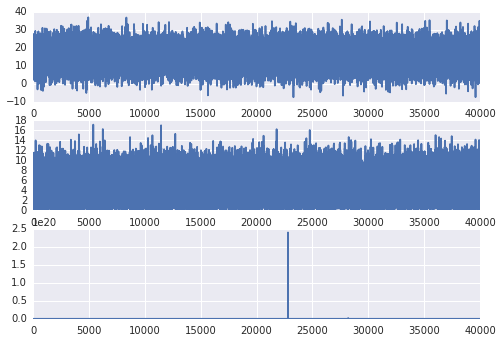

In [59]:
ax = plt.subplot(311)
plt.plot(mu_samples)

ax = plt.subplot(312)
plt.plot(tau_samples)

ax = plt.subplot(313)
plt.plot(rev_samples)

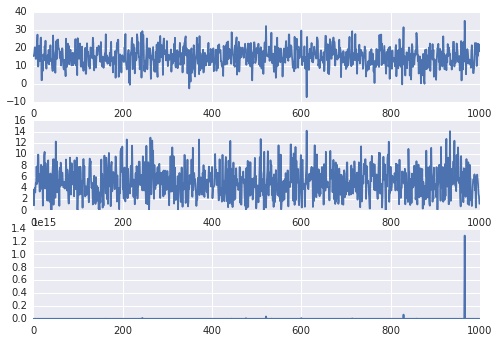

In [61]:
ax = plt.subplot(311)
plt.plot(mu_samples[39000:])

ax = plt.subplot(312)
plt.plot(tau_samples[39000:])

ax = plt.subplot(313)
plt.plot(rev_samples[39000:])

In [63]:
model = pm.Model([obs_y, rev, rev_mu, rev_tau])
mcmc = pm.MCMC(model)
mcmc.sample(100000)

 [-----------------100%-----------------] 100000 of 100000 complete in 8.4 sec

/usr/local/lib/python3.4/dist-packages/pymc/StepMethods.py:779: UserWarning: DrawFromPrior jumped to forbidden value
  warnings.warn('DrawFromPrior jumped to forbidden value')


In [64]:
mu_samples = mcmc.trace("rev_mu")[:]
tau_samples = mcmc.trace("rev_tau")[:]
rev_samples = mcmc.trace("rev")[:]

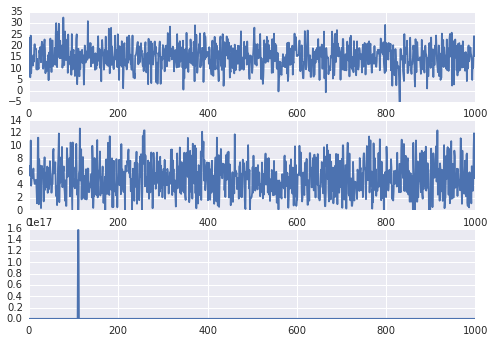

In [67]:
ax = plt.subplot(311)
plt.plot(mu_samples[99000:])

ax = plt.subplot(312)
plt.plot(tau_samples[99000:])

ax = plt.subplot(313)
plt.plot(rev_samples[99000:])

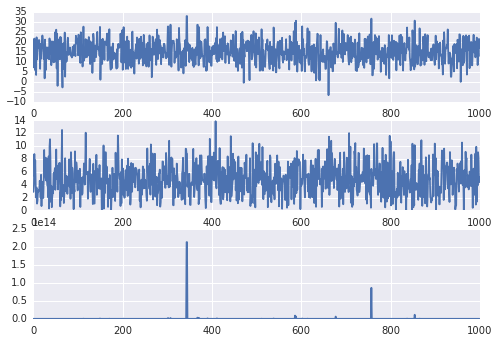

In [68]:
ax = plt.subplot(311)
plt.plot(mu_samples[:1000])

ax = plt.subplot(312)
plt.plot(tau_samples[:1000])

ax = plt.subplot(313)
plt.plot(rev_samples[:1000])

Plotting rev
Plotting rev_mu
Plotting rev_tau


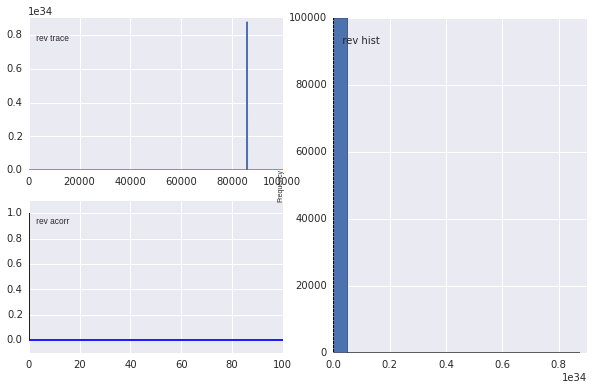

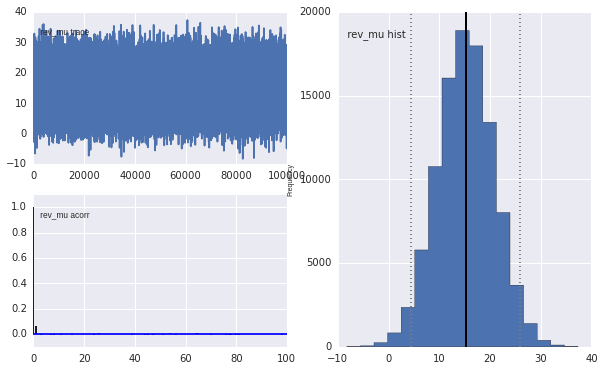

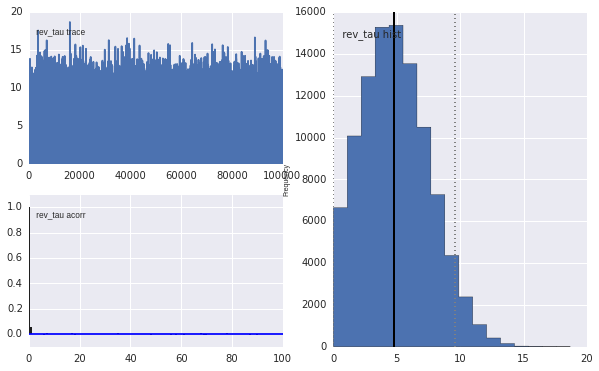

In [70]:
from pymc.Matplot import plot as mcplot
mcplot(mcmc)

In [71]:
mu_init

15.18664153384384

In [72]:
tau_init

4.5216334139554242

In [73]:
mu_init = np.log(np.median(y))
sigma_init = np.sqrt((np.log(np.mean(y))-mu_init)*2)
tau_init = 0.5/(np.log(np.mean(y))-mu_init)

rev_mu = pm.Normal('rev_mu', mu=mu_init, tau=0.5/mu_init)
rev_tau = pm.Gamma('rev_tau', alpha=tau_init**1.5, beta=tau_init**0.5)

rev = pm.Lognormal('rev', mu=rev_mu, tau=rev_tau)

In [74]:
model = pm.Model([obs_y, rev, rev_mu, rev_tau])
mcmc = pm.MCMC(model)
mcmc.sample(100000)

 [-----------------100%-----------------] 100000 of 100000 complete in 8.3 sec

Plotting rev
Plotting rev_tau
Plotting rev_mu


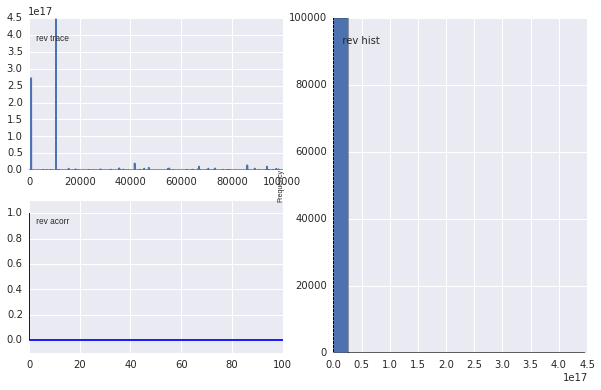

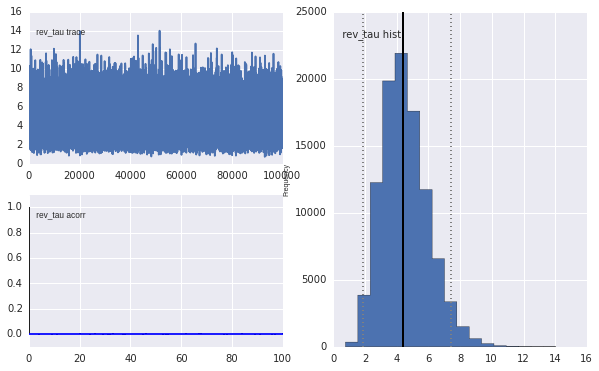

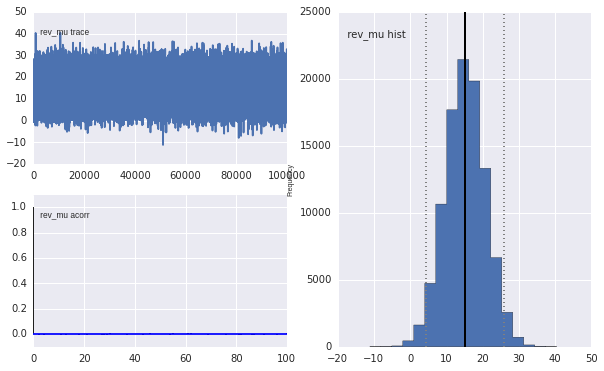

In [75]:
from pymc.Matplot import plot as mcplot
mcplot(mcmc)

In [78]:
import scipy.stats.mstats

In [79]:
scipy.stats.mstats.gmean(mcmc.trace("rev")[:])

3982943.5199900731

In [80]:
scipy.stats.mstats.gmean(y)

3907807.0271324022

## Break